#**Stock prediction using LSTM**

## Table of Content
   
1. [Data Description](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



## Executive Summary

Investing is one of most important business decisions every company deal with, as it is directly related to profits and strategic expansions. One type of invesment involves stocks, which companies usually buy for control/acquisition purposes. Although historical records could provide a lot of information on the target company's standing, future stock values would allow the buyer to optimise their purchase timing. Morover, current stockholders would have a way to monitor upcoming performance of their investments and make sound decisions. Under this context, a predictive model for stock prices is built as a demonstrative example.

The dataset used in the demonstration is the Microsoft Corporation historical data as at September 1, 2022, which consists of stock prices for open, high, close, adjusted close, and share volume. The prediction model built uses Recurrent Neural Network (RNN). This method is well known for its ability to efficiently and effectively learn relationships between linear and non-linear data and is fairly simple to construct despite its ability to solve complex computational problems. In addition, it performs relatively well when the input data are sequential (i.e. the order of the values are relevant and lose meaning when changed position). Therefore, RNN will be applied on the prediction of future stock prices based on historical data.

The experimentation on the application of the RNN model to the dataset will be carried out in the following manner:
*   An optimisation function where varying values of different hyperparameters of the model (e.g. hidden layers, regularizations, initializers, optimizers and learning rates, etc.) will be defined
*   Using a metric (i.e. mean absolute error), the different models created using the optimisation function will be evaluated and the model with the best hyperparameter will be chosen
*   The hyperparameters of the best model will be fitted (i.e. model will be re-trained) to the dataset
*   The model with best metric (i.e. mean absolute) will be evaluated in terms of model loss, error, and prediction ability



<a id = "cell_Preparation"></a>
## 1. Data Description

#### **1.1. Loading of data and standard libraries**

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('MSFT.csv')

#### **1.2. Dataset characteristics**

The dataset used in this experiment (see _Table 1_) is the Microsoft Corporation stock prices as at September 1, 2022. As described in _Table 2_, it is comprised of 9,194 samples with 6 attributes. Figure 1 shows the time series plots for each of the variables. As expected, prices for open, high, low, close, and adjusted close have similar patterns. However, these information are made available at the same day as the closing stock price. Therefore, predictions based on these variables would not be possible. For this reason, new variables will be created based on previous close prices.

It could also be observed that over the years up until 2016, where prices started increasing dramatically, stock prices have been almost stagnant. With this, the values from before 2016 would be insignificant in the analysis. Therefore, only the data for the past five years (from 2017) is utilised in the analysis.

In [ ]:
print('Table 1: Example of loaded data\n')
df.head()

Table 1: Example of loaded data



,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059891,58435200


In [ ]:
print('Table 2: Information about dataset\n')
df.info()

Table 2: Information about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9194 entries, 0 to 9193
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9194 non-null   object 
 1   Open       9194 non-null   float64
 2   High       9194 non-null   float64
 3   Low        9194 non-null   float64
 4   Close      9194 non-null   float64
 5   Adj Close  9194 non-null   float64
 6   Volume     9194 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 502.9+ KB


Figure 1: Time series plot of variables



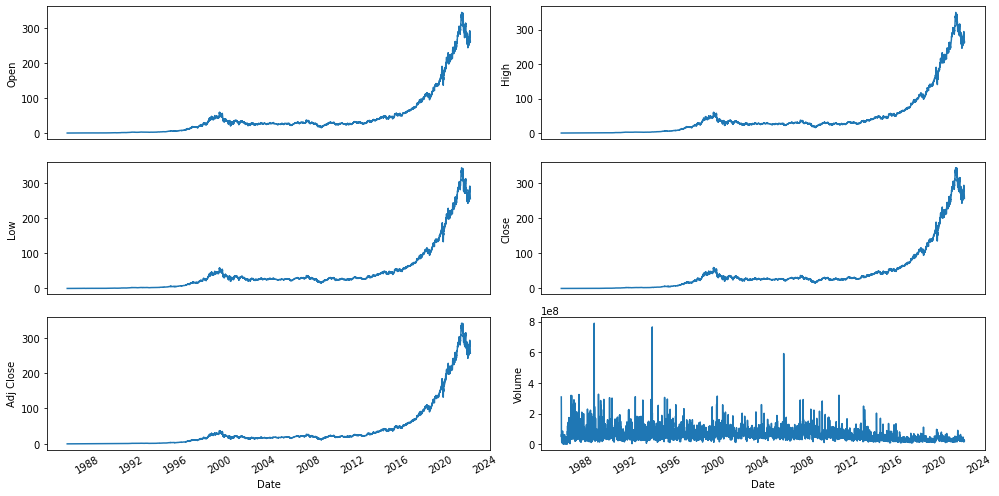

In [ ]:
#Visualising time series data
##Change data type to utilise in visualisation
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

#Plot data
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
print('Figure 1: Time series plot of variables\n')
plt.show()

#### **1.3. Data specification**

The dataset, as shown in _Table 1_, is used in the prediction of stock prices. The variable 'Close' is set as the model target while all new variables derived from previous days' close prices are used as predictors. Necessary pre-processing is utilised to ensure to achieve this.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

The dataset has been explored in order to be able to conduct proper data preparation for modelling. As specified in Section 1.1, the dataset is filtered to include only data from the last five years (i.e. September 01, 2017 to September 01, 2022). New variables pertaining to the stock price close values from the last 3, 2, and 1 trading days are also created, which which will be used as predictors. _Table 3_ shows an extract of the filtered dataset with the newly created variables. The dataset is then split into training and validation data, with the first 80% of values (i.e. 2017 to mid-2021) assigned to the former and last 20% (i.e. mid-2021 to 2022) to the latter, as seen in _Figure 2_.

In [ ]:
#Create new variables containing windows for -3, -2, and -1 of target variable for last 5 years of data
def windowed(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowdf = windowed(df, 
                                '2017-09-01', 
                                '2022-09-01', 
                                n=3)
print('Table 3: Example of windowed data\n')
windowdf.head()

Table 3: Example of windowed data



,Date,Target-3,Target-2,Target-1,Target
0,2017-09-01,73.050003,74.010002,74.769997,73.940002
1,2017-09-05,74.010002,74.769997,73.940002,73.610001
2,2017-09-06,74.769997,73.940002,73.610001,73.400002
3,2017-09-07,73.940002,73.610001,73.400002,74.339996
4,2017-09-08,73.610001,73.400002,74.339996,73.980003


In [ ]:
#Prepare data for modelling
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowdf)

print('Result 1: Dataset shapes\n')
dates.shape, X.shape, y.shape

Result 1: Dataset shapes



((1259,), (1259, 3, 1), (1259,))

Figure 2: Graph of training and validation data



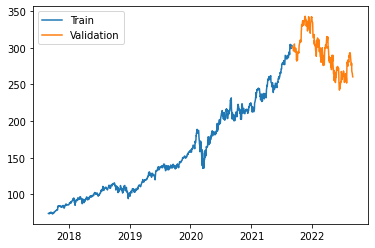

In [ ]:
#Split training and validation sets
q_80 = int(len(dates) * .8)
q_100 = int(len(dates))

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_100], X[q_80:q_100], y[q_80:q_100]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
print('Figure 2: Graph of training and validation data\n')
plt.legend(['Train', 'Validation'])

<a id = "cell_model"></a>
## 3. Model Construction

Recurrent Neural Network (RNN) with Long short-term memory (LSTM) is utislised to predict stock prices of Microsoft Corporation using tensorflow keras. To derive the best model architecture for the problem, a function to determine the optimal number of LSTM units and dense layers and units, and the most effective initializer, regularizer, and optimizer is defined.

The experiment has been run for 5 trials with 500 epochs each trial. _Result 3_ shows the number of hidden layers and optimal hyperparameters for the top 3 models constructed using the optimisation function. Generally, all 3 models consists of 2 hidden layers. All the other hyperparameters, however, vary. The following describes the hyperparameters for each of the models:
*   Top 1: Uses NAdam optimizer, L1 and L2 for bias regularizations, L1 for kernel regularization, he_normal and glorot_normal as initializers, and has no dropout layers
*   Top 2: Uses RMSprop optimizer, L1 and L2 for bias regularizations, L1 and L2 for kernel regularization, glorot_normal as initializer, and has no dropout layers
*   Top 3: Uses RMSprop optimizer, L1 and L1L2 for bias regularizations, L1 for kernel regularization, random_normal and glorot_normal as initializers, and has no dropout layers

In [ ]:
pip install -U keras-tuner

In [ ]:
#Import libraries for modelling
import tensorflow as tf
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras_tuner.tuners import RandomSearch

In [ ]:
#Define function to build model with the best hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(layers.Input((3, 1)))
    model.add(layers.LSTM(units=hp.Int("l_units", min_value=32, max_value=64)))
    # Tune the number of layers
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            Dense(
                # Tune number of units and activation functions separately
                units=hp.Int(f"units_{i}", min_value=24, max_value=60, step=8),
                activation="relu",
                kernel_initializer=hp.Choice(f"kin_{i}", ["glorot_normal", "he_normal","random_normal"]),
                kernel_regularizer=hp.Choice(f"kreg_{i}", ["L1", "L2", "L1L2"]),
                bias_regularizer=hp.Choice(f"breg_{i}", ["L1", "L2", "L1L2"]),
            )
        )
        if hp.Boolean("dropout"):
          model.add(Dropout(rate=0.2))

    model.add(Dense(1))

    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    hp_optimizer=hp.Choice('optimizer', values=['adam', 'nadam', 'SGD', 'RMSprop'])
    if hp_optimizer == 'SGD':
      optim = SGD(learning_rate=hp_lr)
    elif hp_optimizer == 'RMSprop':
      optim = RMSprop(learning_rate=hp_lr)
    elif hp_optimizer == 'adam':
      optim = Adam(learning_rate=hp_lr)
    elif hp_optimizer == 'nadam':
      optim = Nadam(learning_rate=hp_lr)
    else:
      raise

    model.compile(
        optimizer=optim,
        loss="mse",
        metrics=["mean_absolute_error"],
    )
    return model

In [ ]:
#Embed defined model in search operation
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_mean_absolute_error",
    max_trials=5,
    executions_per_trial=3,
    seed=0,
    overwrite=True,
    directory="my_dir",
    project_name="stock",
)

In [ ]:
#Define callback arguments
from tensorflow.keras.callbacks import EarlyStopping

keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [ ]:
#Fit model to find best parameters
print('Result 2: Best model accuracy report\n')
tuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val),callbacks=keras_callbacks)

Trial 5 Complete [00h 00m 20s]
val_mean_absolute_error: nan

Best val_mean_absolute_error So Far: 7.533650557200114
Total elapsed time: 00h 10m 37s


In [ ]:
#Produce hyperparameters summary of best model found
print('Result 3: Hyperparameters summary for top 3 models found\n')
tuner.results_summary(3)

Result 3: Hyperparameters summary for top 3 models found

Results summary
Results in my_dir/stock
Showing 3 best trials
Trial summary
Hyperparameters:
l_units: 35
num_layers: 2
units_0: 56
kin_0: he_normal
kreg_0: L2
breg_0: L1
dropout: False
lr: 0.00028045052802594774
optimizer: nadam
units_1: 40
kin_1: glorot_normal
kreg_1: L1
breg_1: L1
Score: 7.533650557200114
Trial summary
Hyperparameters:
l_units: 62
num_layers: 2
units_0: 24
kin_0: glorot_normal
kreg_0: L1
breg_0: L2
dropout: False
lr: 0.0002299978470646317
optimizer: RMSprop
units_1: 32
kin_1: glorot_normal
kreg_1: L2
breg_1: L1
Score: 8.076897621154785
Trial summary
Hyperparameters:
l_units: 44
num_layers: 2
units_0: 40
kin_0: random_normal
kreg_0: L1
breg_0: L1L2
dropout: False
lr: 0.0006120819894256405
optimizer: RMSprop
units_1: 24
kin_1: glorot_normal
kreg_1: L1
breg_1: L1
Score: 10.284483909606934


In [ ]:
#View model architecture
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.build(input_shape=(None,3))
print('Table 6: Architecture of model with best hyperparameters\n')
best_model.summary()

Table 6: Architecture of model with best hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35)                5180      
                                                                 
 dense (Dense)               (None, 56)                2016      
                                                                 
 dense_1 (Dense)             (None, 40)                2280      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 9,517
Trainable params: 9,517
Non-trainable params: 0
_________________________________________________________________


While _Result 3_ shows a summary of hyperparameters for the top 3 models found in the experiment, the model that will be used ultimately for the model fitting is the one with the least absolute error on the validation stage (i.e. 7.53). The model is built with an LSTM with 35 units, 2 hidden layers, and 1 output layer, with NAdam (learing rate = 0.0003) as the optimizer. The inputs for each dense layer vary from 40 to 56, with each input layer having different values for the kernel initializer (i.e. he_normal or glorot_normal), bias and kernel regularizers (i.e. L1 or L2). The input layers made use of the relu activation function, which is optimal for linear problems. The output node is set to 1 without any activation function to avoid limiting the value of predicted outputs between 0 and 1. Additioanlly, the loss function used is mean square error with metric to minimise as mean absolute error.

The following explains the model architecture of the best model for each constructed layer:

*   LSTM: (147 inputs + 1 bias) * 35 hidden nodes = 5,180 parameters
*   Layer 1: (35 inputs + 1 bias) * 56 hidden nodes = 2,016 parameters
*   Layer 2: (56 inputs + 1 bias) * 40 hidden nodes = 2,280 parameters
*   Output layer: (40 inputs + 1 bias) * 1 output nodes = 41 parameters

<a id = "cell_execution"></a>
## 4. Model Execution

The hyperparameters of the best model identified in the model construction stage are applied to the validation data during the model execution (i.e. re-training) stage. The model is run for a maximum of 500 epochs. The learning curve metrics utilised, as described in Section 3, are loss (i.e. mean square error) and mean absolute error. The model converged at the 277th epoch.

In [ ]:
# Get the top hyperparameters
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hyperparameters
model = build_model(best_hps[0])

In [ ]:
#Retrain the model using the best hyperparameters
history = model.fit(X_train, y_train,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=keras_callbacks
    )

<a id = "cell_report"></a>
## 5. Experiments Report

The model is evaluated in terms of loss (i.e. mean square error) and mean absolute error. An overall mean absolute error of 7.35 is achieved for the validation stage with a 98.25 loss.

The _Figure 3_ 'Training vs Validation loss' graph shows the model loss for training and validation stages over the epochs. With a decreasing convex downward slope for both stages, it can be deduced that the model fits both the training and validation data very well. On the other hand, the _Figure 3_  'Training vs Validation mean_square_error' graph exhibits the error of the model for training and validation stages over the epochs. As illustrated, the errors follow a decreasing curve for both stages, which denotes good prediction power of the model.

To examine how well the model can predict stock prices, both training and validation data are fitted to the model, as seen in the graphs on _Figures 4 and 5_. As observed, the model was able to predict values that are very close to the actual ones on both sets, especially during the training stage where difference is almost unnoticeable. There is an off prediction for stock prices from November 2021 to January 2022 for the validation stage. Instances such as these, which might be related to unpredictable economic events, would be hard for the model to predict considering the variables used are only related to historical prices. Further expermimentation on related variables would be optimal to improve the prediction power of the model.

The constructed model can be used to make predictions on future stock prices. This would allow companies to make sound decisions on their investments (i.e. whether to invest in a new company, sell non-profiting stocks, etc.). This would in turn create opportunities in terms of business acquisitions, capital creation, and profit generation. The created model can be run by companies in fixed intervals (e.g. quarterly) or right before making important investment decisions.

In [ ]:
#Evaluating performance of the model
train_score = model.evaluate(X_train, y_train, verbose=0)
valid_score = model.evaluate(X_val, y_val, verbose=0)

print('Train error: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val error: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train error:  1.8992 , Train Loss:  10.8725
Val error:  7.3529 , Val Loss:  98.2535


In [ ]:
#Visualising model performance
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

Figure 3: Graphs of training vs validation loss and mean absolute error



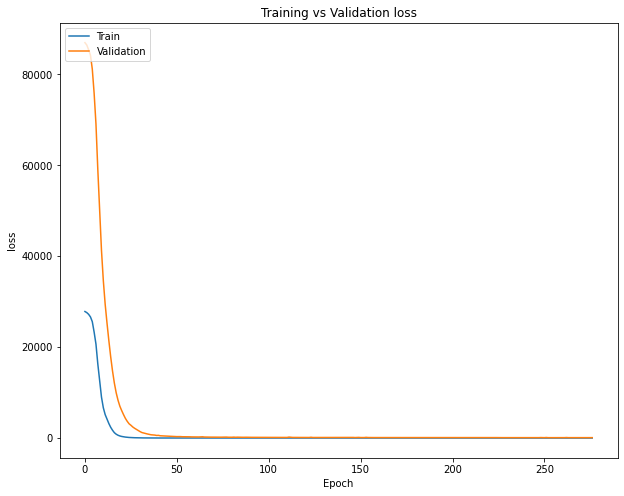

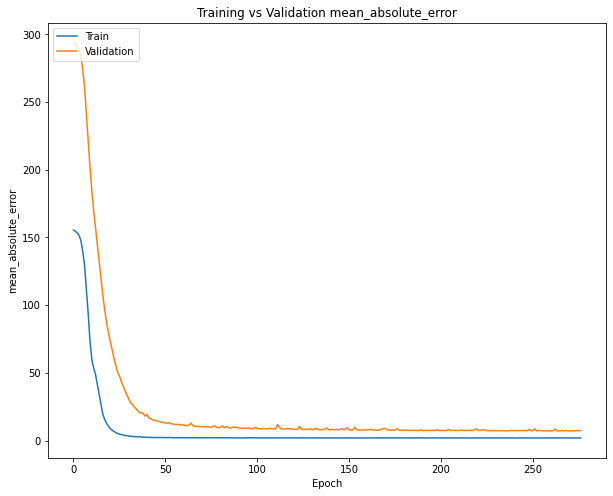

In [ ]:
#Plot training history
import math
hist = pd.DataFrame(history.history)
print('Figure 3: Graphs of training vs validation loss and mean absolute error\n')
plot_hist(hist, xsize=10, ysize=8)

Figure 4: Training Actual vs Predicted values



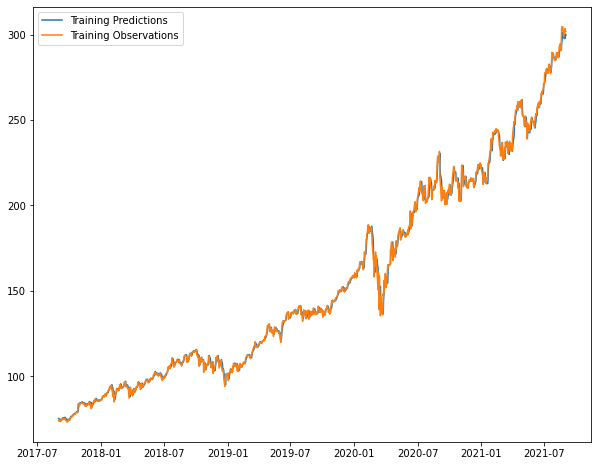

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
print('Figure 4: Training Actual vs Predicted values\n')
plt.legend(['Training Predictions', 'Training Observations'])

Validation Actual vs Predicted values



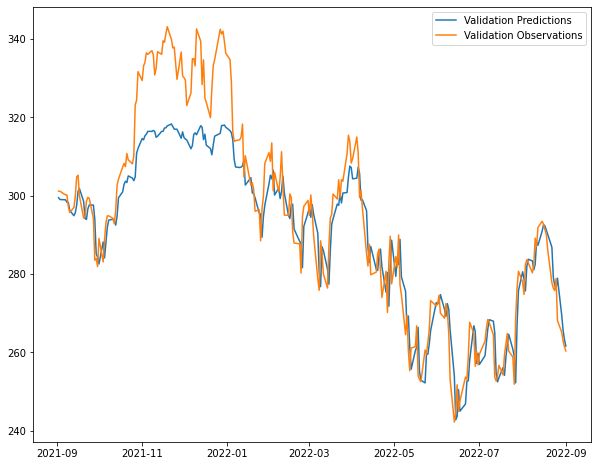

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
print('Validation Actual vs Predicted values\n')
plt.legend(['Validation Predictions', 'Validation Observations'])